In [12]:
import os
import re
import random
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset

# --- CONFIGURATION (ANTI-OVERFITTING) ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


# ****1.Configuration****

In [14]:
CHECKPOINT_DIR = '/kaggle/working/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Data Params
DATASET_NAME    = "Nan-Do/code-search-net-python"
MAX_SRC_LEN     = 50
MAX_TRG_LEN     = 80
BATCH_SIZE      = 64
FREQ_THRESHOLD  = 10   

# Model Params (Reduced Capacity)
EMBED_DIM       = 128    
HIDDEN_DIM      = 256    
NUM_LAYERS      = 2
DROPOUT         = 0.5    
LEARNING_RATE   = 0.001
WEIGHT_DECAY    = 1e-4   
NUM_EPOCHS      = 25    
CLIP_GRAD       = 1.0

# Special Tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = '<PAD>', '<SOS>', '<EOS>', '<UNK>'

print(f"Device: {device} | Freq Threshold: {FREQ_THRESHOLD} | Dropout: {DROPOUT}")

Device: cuda | Freq Threshold: 10 | Dropout: 0.5


# **2. Tokenizer & vocabulary**

In [15]:
# --- TOKENIZER ---
def tokenize(text):
    text = text.strip().replace('\n', ' NEWLINE ').replace('\t', ' INDENT ')
    return re.findall(r'[a-zA-Z_][a-zA-Z0-9_]*|[0-9]+|[^\s]', text)

# --- VOCABULARY ---
class Vocabulary:
    def __init__(self):
        self.itos = {PAD_IDX:PAD_TOKEN, SOS_IDX:SOS_TOKEN, EOS_IDX:EOS_TOKEN, UNK_IDX:UNK_TOKEN}
        self.stoi = {v:k for k,v in self.itos.items()}
        
    def build(self, token_lists):
        counter = Counter()
        for t in token_lists: counter.update(t)
        idx = len(self.itos)
        for w, c in counter.most_common():
            # Uses the new global FREQ_THRESHOLD = 10
            if c >= FREQ_THRESHOLD:
                self.stoi[w] = idx; self.itos[idx] = w; idx += 1
                
    def numericalize(self, tokens):
        return [self.stoi.get(t, UNK_IDX) for t in tokens]
    
    def decode(self, indices):
        return [self.itos.get(i, UNK_TOKEN) for i in indices if i not in [PAD_IDX, SOS_IDX, EOS_IDX]]

# --- DATASET CLASS ---
class CodeDataset(Dataset):
    def __init__(self, docs, codes, sv, tv):
        self.docs, self.codes, self.sv, self.tv = docs, codes, sv, tv
    def __len__(self): return len(self.docs)
    def __getitem__(self, i):
        s = [SOS_IDX] + self.sv.numericalize(self.docs[i][:MAX_SRC_LEN]) + [EOS_IDX]
        t = [SOS_IDX] + self.tv.numericalize(self.codes[i][:MAX_TRG_LEN]) + [EOS_IDX]
        return torch.tensor(s), torch.tensor(t)

def collate_fn(batch):
    s, t = zip(*batch)
    return pad_sequence(s, batch_first=True, padding_value=PAD_IDX), \
           pad_sequence(t, batch_first=True, padding_value=PAD_IDX)

# **3. Data Loading**

In [16]:
# --- LOAD DATA ---
print(f"Downloading {DATASET_NAME}...")
try:
    raw_data = load_dataset(DATASET_NAME, split='train', trust_remote_code=True)
except Exception as e:
    print(f" Nan-Do failed. Falling back to official CodeSearchNet.")
    raw_data = load_dataset("code_search_net", "python", split='train', trust_remote_code=True)

docs, codes = [], []
total_needed = 12000 

print(f"Filtering data...")
for x in raw_data:
    d = x.get('func_documentation_string') or x.get('docstring') or ''
    c = x.get('func_code_string') or x.get('code') or ''
    if d.strip() and c.strip():
        # Quick length check to avoid extremely long sequences
        d_toks = tokenize(d)
        c_toks = tokenize(c)
        if len(d_toks) < 150 and len(c_toks) < 200:
            docs.append(d_toks)
            codes.append(c_toks)
    if len(docs) >= total_needed: break

# Split
train_d, train_c = docs[:10000], codes[:10000]
val_d, val_c     = docs[10000:11000], codes[10000:11000]
test_d, test_c   = docs[11000:12000], codes[11000:12000]

# Vocab
print("Building Vocabulary (Threshold=10)...")
src_vocab = Vocabulary(); src_vocab.build(train_d)
trg_vocab = Vocabulary(); trg_vocab.build(train_c)
SRC_V_SIZE, TRG_V_SIZE = len(src_vocab.itos), len(trg_vocab.itos)

# Loaders
train_loader = DataLoader(CodeDataset(train_d, train_c, src_vocab, trg_vocab), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(CodeDataset(val_d, val_c, src_vocab, trg_vocab), batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader  = DataLoader(CodeDataset(test_d, test_c, src_vocab, trg_vocab), batch_size=BATCH_SIZE, collate_fn=collate_fn)

print(f"New Vocab Sizes: Src={SRC_V_SIZE}, Trg={TRG_V_SIZE} (Should be much smaller)")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Nan-Do/code-search-net-python' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Filtering data...
Building Vocabulary (Threshold=10)...
New Vocab Sizes: Src=2302, Trg=4691 (Should be much smaller)


# **4. Model Architecture**

In [17]:
# --- 1. VANILLA RNN ---
class VanillaRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.RNN(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.dec = nn.RNN(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.enc_emb = nn.Embedding(SRC_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.dec_emb = nn.Embedding(TRG_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.fc = nn.Linear(HIDDEN_DIM, TRG_V_SIZE)
        self.drop = nn.Dropout(DROPOUT)

    def forward(self, src, trg, tf=0.5):
        _, h = self.enc(self.drop(self.enc_emb(src)))
        outputs = []
        inp = trg[:, 0]
        for t in range(1, trg.shape[1]):
            emb = self.drop(self.dec_emb(inp.unsqueeze(1)))
            out, h = self.dec(emb, h)
            pred = self.fc(out.squeeze(1))
            outputs.append(pred.unsqueeze(1))
            inp = trg[:, t] if random.random() < tf else pred.argmax(1)
        return torch.cat(outputs, dim=1)

In [18]:
# --- 2. LSTM ---
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.LSTM(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.dec = nn.LSTM(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.enc_emb = nn.Embedding(SRC_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.dec_emb = nn.Embedding(TRG_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.fc = nn.Linear(HIDDEN_DIM, TRG_V_SIZE)
        self.drop = nn.Dropout(DROPOUT)

    def forward(self, src, trg, tf=0.5):
        _, (h, c) = self.enc(self.drop(self.enc_emb(src)))
        outputs = []
        inp = trg[:, 0]
        for t in range(1, trg.shape[1]):
            emb = self.drop(self.dec_emb(inp.unsqueeze(1)))
            out, (h, c) = self.dec(emb, (h, c))
            pred = self.fc(out.squeeze(1))
            outputs.append(pred.unsqueeze(1))
            inp = trg[:, t] if random.random() < tf else pred.argmax(1)
        return torch.cat(outputs, dim=1)


In [19]:
# --- 3. ATTENTION ---
import torch.nn.functional as F  

class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.LSTM(EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, batch_first=True, bidirectional=True, dropout=DROPOUT)
        self.dec = nn.LSTM(EMBED_DIM + HIDDEN_DIM*2, HIDDEN_DIM, NUM_LAYERS, batch_first=True, dropout=DROPOUT)
        self.enc_emb = nn.Embedding(SRC_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.dec_emb = nn.Embedding(TRG_V_SIZE, EMBED_DIM, padding_idx=PAD_IDX)
        self.fc_out = nn.Linear(HIDDEN_DIM + HIDDEN_DIM*2 + EMBED_DIM, TRG_V_SIZE)
        
        self.W1 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM, bias=False)
        self.W2 = nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM, bias=False)
        self.V = nn.Linear(HIDDEN_DIM, 1, bias=False)
        self.fc_h = nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM)
        self.fc_c = nn.Linear(HIDDEN_DIM*2, HIDDEN_DIM)
        self.drop = nn.Dropout(DROPOUT)

    def calc_attn(self, hidden, enc_out, mask):
        score = torch.tanh(self.W1(hidden.unsqueeze(1)) + self.W2(enc_out))
        attn = self.V(score).squeeze(2)
        attn.masked_fill_(mask==0, -1e10)
        weights = F.softmax(attn, dim=1)
        ctx = torch.bmm(weights.unsqueeze(1), enc_out).squeeze(1)
        return ctx, weights

    def forward(self, src, trg, tf=0.5):
        enc_out, (h, c) = self.enc(self.drop(self.enc_emb(src)))
        h = torch.tanh(self.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
        c = torch.tanh(self.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
        
        outputs = []
        inp = trg[:, 0]
        mask = (src != PAD_IDX)
        
        for t in range(1, trg.shape[1]):
            emb = self.drop(self.dec_emb(inp.unsqueeze(1)))
            ctx, _ = self.calc_attn(h[-1], enc_out, mask)
            rnn_in = torch.cat((emb, ctx.unsqueeze(1)), dim=2)
            out, (h, c) = self.dec(rnn_in, (h, c))
            pred = self.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
            outputs.append(pred.unsqueeze(1))
            inp = trg[:, t] if random.random() < tf else pred.argmax(1)
        return torch.cat(outputs, dim=1)

# **6. Training Models**

In [20]:
def calc_accuracy(output, trg):
    preds = output.argmax(dim=1, keepdim=True).squeeze()
    mask = trg != PAD_IDX
    correct = (preds == trg) & mask
    return correct.sum().item(), mask.sum().item()

def evaluate_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0
    
    with torch.no_grad():
        for src, trg in loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, tf=0) 
            
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim) 
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            n_correct, n_total = calc_accuracy(output, trg)
            epoch_correct += n_correct
            epoch_total += n_total
            
    return epoch_loss / len(loader), (epoch_correct / epoch_total * 100) if epoch_total > 0 else 0

def train_model(name, model):
    print(f"\n{'='*60}\nTraining {name}\n{'='*60}")
    # ADDED WEIGHT DECAY
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    best_val_loss = float('inf')
    
    for ep in range(NUM_EPOCHS):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for src, trg in train_loader:
            src, trg = src.to(device), trg.to(device)
            optimizer.zero_grad()
            output = model(src, trg, tf=0.5)
            
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
            optimizer.step()
            
            train_loss += loss.item()
            n_correct, n_total = calc_accuracy(output, trg)
            train_correct += n_correct
            train_total += n_total
            
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = (train_correct / train_total) * 100 if train_total > 0 else 0
        avg_val_loss, avg_val_acc = evaluate_epoch(model, val_loader, criterion)
        
        save_msg = ""
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{name}_best.pth"))
            save_msg = " -> Saved Best"
            
        print(f"Ep {ep+1:02}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} Acc: {avg_val_acc:.2f}%{save_msg}")

# --- INIT & TRAIN ---
rnn = VanillaRNN().to(device)
lstm = LSTM().to(device)
attn = Attention().to(device)

train_model("Vanilla_RNN", rnn)



Training Vanilla_RNN
Ep 01/25 | Train Loss: 4.8666 Acc: 17.79% | Val Loss: 4.3175 Acc: 18.30% -> Saved Best
Ep 02/25 | Train Loss: 4.3015 Acc: 24.79% | Val Loss: 5.4038 Acc: 10.03%
Ep 03/25 | Train Loss: 4.1581 Acc: 26.44% | Val Loss: 4.4148 Acc: 16.83%
Ep 04/25 | Train Loss: 4.0780 Acc: 27.46% | Val Loss: 4.5727 Acc: 14.87%
Ep 05/25 | Train Loss: 4.0306 Acc: 28.04% | Val Loss: 4.4419 Acc: 17.00%
Ep 06/25 | Train Loss: 3.9998 Acc: 28.43% | Val Loss: 4.3906 Acc: 16.47%
Ep 07/25 | Train Loss: 3.9492 Acc: 29.15% | Val Loss: 4.4432 Acc: 16.60%
Ep 08/25 | Train Loss: 3.9197 Acc: 29.66% | Val Loss: 4.4313 Acc: 16.46%
Ep 09/25 | Train Loss: 3.8875 Acc: 30.00% | Val Loss: 4.4525 Acc: 16.56%
Ep 10/25 | Train Loss: 3.8776 Acc: 30.08% | Val Loss: 4.5591 Acc: 15.37%
Ep 11/25 | Train Loss: 3.8506 Acc: 30.35% | Val Loss: 4.4743 Acc: 16.41%
Ep 12/25 | Train Loss: 3.8574 Acc: 30.25% | Val Loss: 4.4122 Acc: 16.46%
Ep 13/25 | Train Loss: 3.8233 Acc: 30.79% | Val Loss: 5.4384 Acc: 13.07%
Ep 14/25 | Trai

In [21]:
train_model("LSTM", lstm)



Training LSTM
Ep 01/25 | Train Loss: 5.0285 Acc: 14.12% | Val Loss: 4.2834 Acc: 18.11% -> Saved Best
Ep 02/25 | Train Loss: 4.6203 Acc: 19.09% | Val Loss: 4.2398 Acc: 17.51% -> Saved Best
Ep 03/25 | Train Loss: 4.3463 Acc: 23.99% | Val Loss: 4.2272 Acc: 18.18% -> Saved Best
Ep 04/25 | Train Loss: 4.1514 Acc: 26.71% | Val Loss: 4.2858 Acc: 17.29%
Ep 05/25 | Train Loss: 4.0634 Acc: 27.72% | Val Loss: 4.2805 Acc: 17.66%
Ep 06/25 | Train Loss: 3.9900 Acc: 28.73% | Val Loss: 4.4358 Acc: 16.59%
Ep 07/25 | Train Loss: 3.9384 Acc: 29.34% | Val Loss: 4.5285 Acc: 17.39%
Ep 08/25 | Train Loss: 3.8992 Acc: 29.87% | Val Loss: 4.4878 Acc: 16.97%
Ep 09/25 | Train Loss: 3.8541 Acc: 30.52% | Val Loss: 4.4231 Acc: 18.77%
Ep 10/25 | Train Loss: 3.8139 Acc: 31.13% | Val Loss: 4.3181 Acc: 19.16%
Ep 11/25 | Train Loss: 3.7734 Acc: 31.80% | Val Loss: 4.3049 Acc: 19.40%
Ep 12/25 | Train Loss: 3.7604 Acc: 31.92% | Val Loss: 4.2705 Acc: 19.19%
Ep 13/25 | Train Loss: 3.7407 Acc: 32.18% | Val Loss: 4.2857 Acc: 1

In [22]:
train_model("Attention", attn)


Training Attention
Ep 01/25 | Train Loss: 4.6837 Acc: 19.98% | Val Loss: 4.1984 Acc: 19.35% -> Saved Best
Ep 02/25 | Train Loss: 4.0948 Acc: 25.84% | Val Loss: 4.1594 Acc: 19.87% -> Saved Best
Ep 03/25 | Train Loss: 3.8589 Acc: 29.28% | Val Loss: 4.1132 Acc: 20.66% -> Saved Best
Ep 04/25 | Train Loss: 3.6540 Acc: 32.08% | Val Loss: 4.1558 Acc: 20.19%
Ep 05/25 | Train Loss: 3.4706 Acc: 34.73% | Val Loss: 4.1403 Acc: 20.86%
Ep 06/25 | Train Loss: 3.2975 Acc: 37.38% | Val Loss: 4.2088 Acc: 20.30%
Ep 07/25 | Train Loss: 3.1751 Acc: 39.32% | Val Loss: 4.2321 Acc: 20.15%
Ep 08/25 | Train Loss: 3.0050 Acc: 42.08% | Val Loss: 4.2235 Acc: 21.91%
Ep 09/25 | Train Loss: 2.9351 Acc: 43.20% | Val Loss: 4.3630 Acc: 21.50%
Ep 10/25 | Train Loss: 2.8368 Acc: 45.15% | Val Loss: 4.2735 Acc: 21.94%
Ep 11/25 | Train Loss: 2.7481 Acc: 46.88% | Val Loss: 4.3338 Acc: 22.41%
Ep 12/25 | Train Loss: 2.6744 Acc: 48.39% | Val Loss: 4.3869 Acc: 21.84%
Ep 13/25 | Train Loss: 2.6093 Acc: 49.61% | Val Loss: 4.6174 A

In [23]:
from IPython.display import FileLink, display

print("=" * 70)
print("DOWNLOADABLE MODEL CHECKPOINTS")
print("=" * 70)

# Copy checkpoints to /kaggle/working root for easy download
checkpoint_files = {
    "Vanilla_RNN_best.pth": "vanilla_rnn_best.pt",
    "LSTM_best.pth": "lstm_best.pt",
    "Attention_best.pth": "attention_best.pt"
}

print("\n📦 Creating downloadable checkpoint files...\n")

for original_name, save_name in checkpoint_files.items():
    src_path = os.path.join(CHECKPOINT_DIR, original_name)
    
    if os.path.exists(src_path):
        # Load and save to /kaggle/working root
        state_dict = torch.load(src_path, map_location='cpu', weights_only=True)
        torch.save(state_dict, save_name)
        
        size_mb = os.path.getsize(save_name) / (1024 * 1024)
        print(f"✓ {save_name} saved ({size_mb:.2f} MB)")
        display(FileLink(save_name))
        print()
    else:
        print(f"✗ {original_name} - NOT FOUND\n")

print("=" * 70)
print("✓ All checkpoints ready! Click the links above to download.")
print("=" * 70)


DOWNLOADABLE MODEL CHECKPOINTS

📦 Creating downloadable checkpoint files...

✓ vanilla_rnn_best.pt saved (9.78 MB)


/kaggle/working/vanilla_rnn_best.pt


✓ lstm_best.pt saved (15.05 MB)


/kaggle/working/lstm_best.pt


✓ attention_best.pt saved (35.77 MB)


/kaggle/working/attention_best.pt


✓ All checkpoints ready! Click the links above to download.


In [25]:
def evaluate_detailed(name, model, has_attn=False):
    path = os.path.join(CHECKPOINT_DIR, f"{name}_best.pth")
    if not os.path.exists(path): 
        print(f"No checkpoint found for {name}")
        return []
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    
    refs, hyps, attn_maps = [], [], []
    correct_toks, total_toks = 0, 0
    
    print(f"\nEvaluating {name}...")
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            for i in range(src.shape[0]):
                src_seq = src[i:i+1]
                mask = (src_seq != PAD_IDX)
                
                # ENCODING
                if has_attn:
                    enc_out, (h, c) = model.enc(model.drop(model.enc_emb(src_seq)))
                    h = torch.tanh(model.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                    c = torch.tanh(model.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                elif isinstance(model, LSTM):
                    _, (h, c) = model.enc(model.drop(model.enc_emb(src_seq)))
                else:
                    _, h = model.enc(model.drop(model.enc_emb(src_seq)))
                    c = None

                # DECODING
                inp = torch.tensor([SOS_IDX], device=device)
                gen = []
                w_list = []
                
                for _ in range(MAX_TRG_LEN):
                    emb = model.drop(model.dec_emb(inp.unsqueeze(1)))
                    if has_attn:
                        ctx, w = model.calc_attn(h[-1], enc_out, mask)
                        w_list.append(w.cpu())
                        out, (h, c) = model.dec(torch.cat((emb, ctx.unsqueeze(1)), dim=2), (h, c))
                        pred = model.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
                    elif isinstance(model, LSTM):
                        out, (h, c) = model.dec(emb, (h, c))
                        pred = model.fc(out.squeeze(1))
                    else:
                        out, h = model.dec(emb, h)
                        pred = model.fc(out.squeeze(1))
                    
                    top = pred.argmax(1).item()
                    if top == EOS_IDX: break
                    gen.append(top)
                    inp = torch.tensor([top], device=device)
                
                gen_text = ' '.join(trg_vocab.decode(gen))
                ref_text = ' '.join(trg_vocab.decode(trg[i].tolist()))
                
                hyps.append(gen_text)
                refs.append([ref_text])
                
                gen_t = trg_vocab.decode(gen)
                ref_t = trg_vocab.decode(trg[i].tolist())
                match_len = min(len(gen_t), len(ref_t))
                correct_toks += sum(1 for k in range(match_len) if gen_t[k] == ref_t[k])
                total_toks += len(ref_t)
                
                if has_attn and len(w_list)>0 and len(attn_maps)<3 and len(gen_t)>3:
                    attn_maps.append((src_vocab.decode(src[i].tolist()), gen_t, torch.cat(w_list).numpy()))

    from nltk.translate.bleu_score import corpus_bleu
    
    tokenized_refs = [[r[0].split()] for r in refs]
    tokenized_hyps = [h.split() for h in hyps]
    bleu = corpus_bleu(tokenized_refs, tokenized_hyps) * 100
    
    acc = (correct_toks / total_toks * 100) if total_toks > 0 else 0
    em = sum([1 for r, h in zip(refs, hyps) if r[0] == h]) / len(refs) * 100
    
    print(f"Results >> BLEU: {bleu:.2f} | Token Acc: {acc:.2f}% | Exact Match: {em:.2f}%")
    return attn_maps

# Evaluate All
_ = evaluate_detailed("Vanilla_RNN", rnn)
_ = evaluate_detailed("LSTM", lstm)
maps = evaluate_detailed("Attention", attn, has_attn=True)



Evaluating Vanilla_RNN...
Results >> BLEU: 11.16 | Token Acc: 19.13% | Exact Match: 0.00%

Evaluating LSTM...
Results >> BLEU: 19.64 | Token Acc: 18.67% | Exact Match: 0.00%

Evaluating Attention...
Results >> BLEU: 21.26 | Token Acc: 21.06% | Exact Match: 0.00%


# **Attention Visualization**

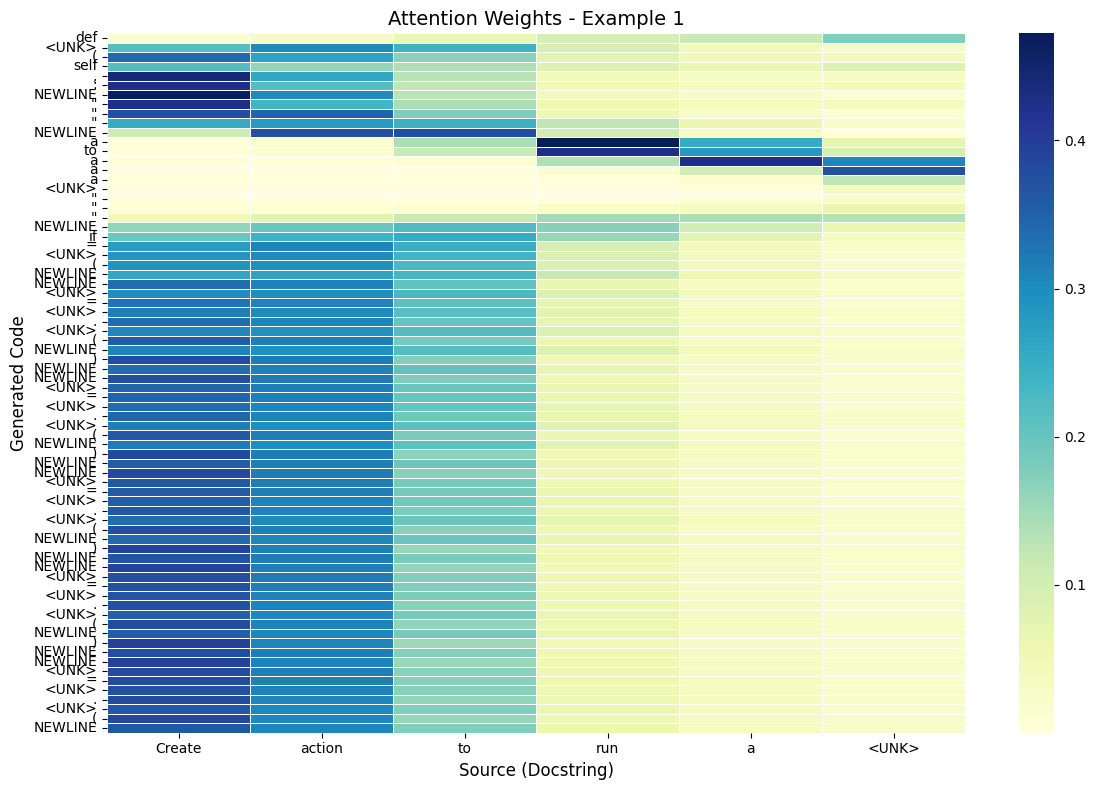

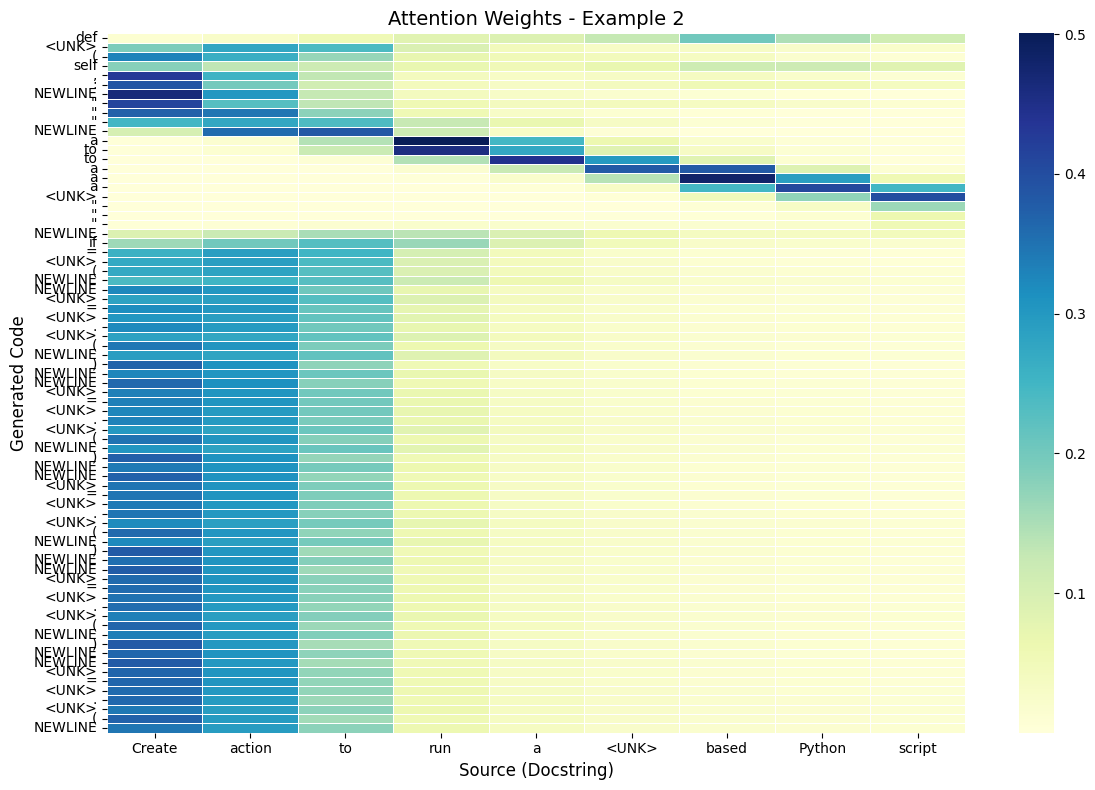

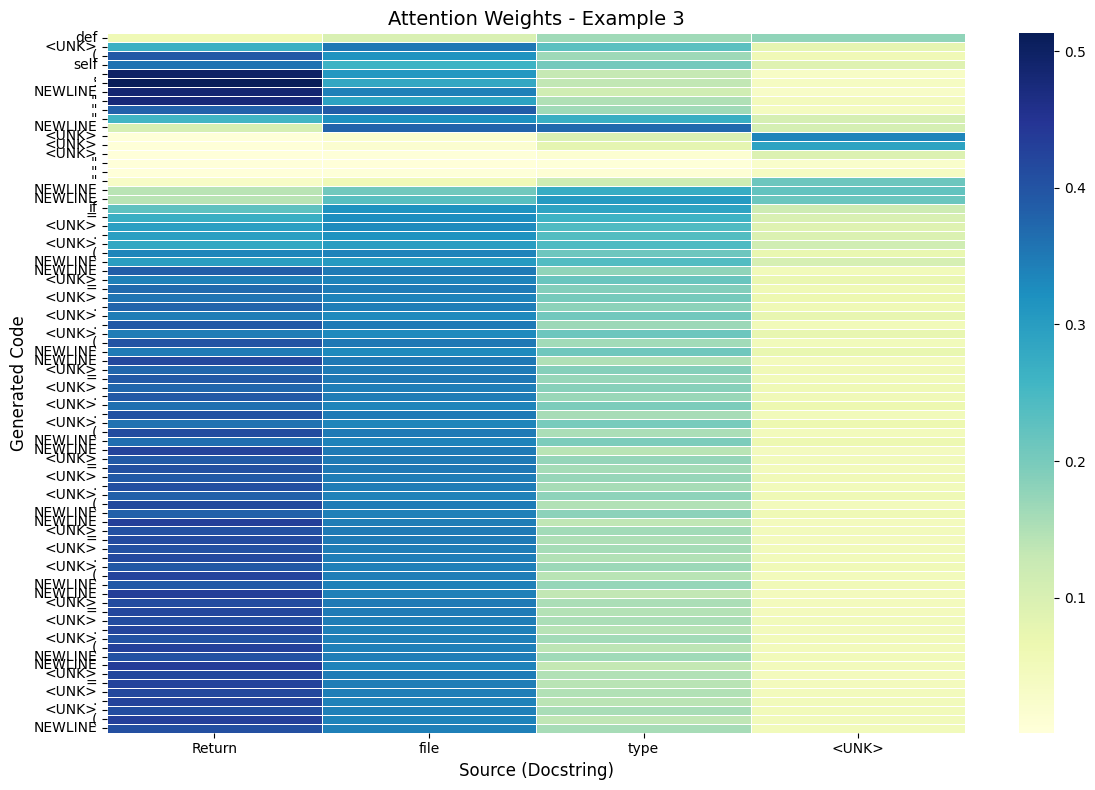

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(src_tokens, trg_tokens, attn_weights, idx):
    """Plot attention heatmap"""
    # Truncate to actual lengths
    src_len = len(src_tokens)
    trg_len = len(trg_tokens)
    
    # Get attention matrix
    attn_matrix = attn_weights[:trg_len, :src_len]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(attn_matrix, xticklabels=src_tokens, yticklabels=trg_tokens, 
                cmap='YlGnBu', cbar=True, linewidths=0.5)
    plt.xlabel('Source (Docstring)', fontsize=12)
    plt.ylabel('Generated Code', fontsize=12)
    plt.title(f'Attention Weights - Example {idx+1}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/attention_map_{idx+1}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot the attention maps
for idx, (src_toks, trg_toks, attn_w) in enumerate(maps):
    plot_attention(src_toks, trg_toks, attn_w, idx)


##  Performance vs Docstring Length Analysis

In [27]:
def analyze_performance_by_length(name, model):
    """Analyze how performance varies with input length"""
    path = os.path.join(CHECKPOINT_DIR, f"{name}_best.pth")
    if not os.path.exists(path): return
    
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    
    length_buckets = {
        '0-10': {'correct': 0, 'total': 0},
        '10-20': {'correct': 0, 'total': 0},
        '20-30': {'correct': 0, 'total': 0},
        '30+': {'correct': 0, 'total': 0}
    }
    
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, tf=0)
            
            for i in range(src.shape[0]):
                src_len = (src[i] != PAD_IDX).sum().item()
                
                # Determine bucket
                if src_len <= 10:
                    bucket = '0-10'
                elif src_len <= 20:
                    bucket = '10-20'
                elif src_len <= 30:
                    bucket = '20-30'
                else:
                    bucket = '30+'
                
                # Calculate accuracy for this sample
                preds = output[i].argmax(dim=1)
                target = trg[i, 1:]
                mask = target != PAD_IDX
                correct = ((preds == target) & mask).sum().item()
                total = mask.sum().item()
                
                length_buckets[bucket]['correct'] += correct
                length_buckets[bucket]['total'] += total
    
    print(f"\n{name} - Performance by Docstring Length:")
    print("-" * 50)
    for bucket, stats in length_buckets.items():
        if stats['total'] > 0:
            acc = (stats['correct'] / stats['total']) * 100
            print(f"Length {bucket:6s}: {acc:5.2f}% ({stats['total']} tokens)")
        else:
            print(f"Length {bucket:6s}: No data")

analyze_performance_by_length("Vanilla_RNN", rnn)
analyze_performance_by_length("LSTM", lstm)
analyze_performance_by_length("Attention", attn)



Vanilla_RNN - Performance by Docstring Length:
--------------------------------------------------
Length 0-10  : 19.47% (30577 tokens)
Length 10-20 : 18.20% (21726 tokens)
Length 20-30 : 19.52% (7060 tokens)
Length 30+   : 18.19% (12645 tokens)

LSTM - Performance by Docstring Length:
--------------------------------------------------
Length 0-10  : 20.34% (30577 tokens)
Length 10-20 : 17.83% (21726 tokens)
Length 20-30 : 16.69% (7060 tokens)
Length 30+   : 15.72% (12645 tokens)

Attention - Performance by Docstring Length:
--------------------------------------------------
Length 0-10  : 23.00% (30577 tokens)
Length 10-20 : 20.41% (21726 tokens)
Length 20-30 : 19.82% (7060 tokens)
Length 30+   : 18.78% (12645 tokens)


In [28]:
def generate_examples(name, model, num_examples=5):
    """Generate code from docstrings"""
    path = os.path.join(CHECKPOINT_DIR, f"{name}_best.pth")
    if not os.path.exists(path): return
    
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    
    print(f"\n{'='*70}")
    print(f"GENERATED CODE EXAMPLES - {name}")
    print(f"{'='*70}\n")
    
    count = 0
    with torch.no_grad():
        for src, trg in test_loader:
            if count >= num_examples: break
            src, trg = src.to(device), trg.to(device)
            
            for i in range(min(3, src.shape[0])):
                if count >= num_examples: break
                
                src_seq = src[i:i+1]
                mask = (src_seq != PAD_IDX)
                
                # Determine model type by class name
                model_type = type(model).__name__
                
                # Encode
                if model_type == 'Attention':
                    enc_out, (h, c) = model.enc(model.drop(model.enc_emb(src_seq)))
                    h = torch.tanh(model.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                    c = torch.tanh(model.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                elif model_type == 'LSTM':
                    _, (h, c) = model.enc(model.drop(model.enc_emb(src_seq)))
                else:  # VanillaRNN
                    _, h = model.enc(model.drop(model.enc_emb(src_seq)))
                    c = None
                
                # Decode
                inp = torch.tensor([SOS_IDX], device=device)
                gen = []
                
                for _ in range(MAX_TRG_LEN):
                    emb = model.drop(model.dec_emb(inp.unsqueeze(1)))
                    
                    if model_type == 'Attention':
                        # Attention model: concatenate embedding with context
                        ctx, _ = model.calc_attn(h[-1], enc_out, mask)
                        rnn_in = torch.cat((emb, ctx.unsqueeze(1)), dim=2)
                        out, (h, c) = model.dec(rnn_in, (h, c))
                        pred = model.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
                    elif model_type == 'LSTM':
                        # LSTM model
                        out, (h, c) = model.dec(emb, (h, c))
                        pred = model.fc(out.squeeze(1))
                    else:  # VanillaRNN
                        # Vanilla RNN model
                        out, h = model.dec(emb, h)
                        pred = model.fc(out.squeeze(1))
                    
                    top = pred.argmax(1).item()
                    if top == EOS_IDX: break
                    gen.append(top)
                    inp = torch.tensor([top], device=device)
                
                src_text = ' '.join(src_vocab.decode(src[i].tolist()))
                gen_text = ' '.join(trg_vocab.decode(gen))
                ref_text = ' '.join(trg_vocab.decode(trg[i].tolist()))
                
                print(f"Example {count+1}:")
                print(f"  Docstring: {src_text}")
                print(f"  Generated: {gen_text}")
                print(f"  Reference: {ref_text}")
                print()
                
                count += 1
            
            if count >= num_examples: break

generate_examples("Vanilla_RNN", rnn, num_examples=3)



GENERATED CODE EXAMPLES - Vanilla_RNN

Example 1:
  Docstring: Create action to run a <UNK>
  Generated: def <UNK> ( self , : ) : NEWLINE " " " NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE
  Reference: def <UNK> ( parent , text , name , <UNK> = None , <UNK> = None ) : NEWLINE " " " Create action to run a program " " " NEWLINE if <UNK> ( <UNK> ) : NEWLINE <UNK> = <UNK> ( <UNK> ) NEWLINE if os . name = = ' nt ' and <UNK> is not None : NEWLINE name = <UNK> NEWLINE path = <UNK> . <UNK> ( name ) NEWL

In [29]:
generate_examples("LSTM", lstm, num_examples=3)



GENERATED CODE EXAMPLES - LSTM

Example 1:
  Docstring: Create action to run a <UNK>
  Generated: def <UNK> ( self , : NEWLINE " " " NEWLINE <UNK> <UNK> <UNK> <UNK> . " " " NEWLINE " " " NEWLINE if <UNK> . <UNK> ( <UNK> ) NEWLINE NEWLINE " " " NEWLINE if <UNK> . <UNK> ( <UNK> ) NEWLINE NEWLINE <UNK> = <UNK> ( <UNK> ) NEWLINE NEWLINE <UNK> = <UNK> ( <UNK> ) NEWLINE NEWLINE <UNK> = <UNK> ( NEWLINE NEWLINE <UNK> = <UNK> ( NEWLINE NEWLINE <UNK> = <UNK> ( NEWLINE NEWLINE
  Reference: def <UNK> ( parent , text , name , <UNK> = None , <UNK> = None ) : NEWLINE " " " Create action to run a program " " " NEWLINE if <UNK> ( <UNK> ) : NEWLINE <UNK> = <UNK> ( <UNK> ) NEWLINE if os . name = = ' nt ' and <UNK> is not None : NEWLINE name = <UNK> NEWLINE path = <UNK> . <UNK> ( name ) NEWLINE if path is not None

Example 2:
  Docstring: Create action to run a <UNK> based Python script
  Generated: def <UNK> ( self , : NEWLINE " " " NEWLINE <UNK> <UNK> <UNK> <UNK> . " " " NEWLINE " " " NEWLINE if <UNK> 

In [30]:
generate_examples("Attention", attn, num_examples=3)


GENERATED CODE EXAMPLES - Attention

Example 1:
  Docstring: Create action to run a <UNK>
  Generated: def <UNK> ( self , : NEWLINE " " " NEWLINE a to a a a <UNK> " " " NEWLINE if = <UNK> ( NEWLINE NEWLINE <UNK> = <UNK> . <UNK> ( NEWLINE ) NEWLINE NEWLINE <UNK> = <UNK> . <UNK> ( NEWLINE ) NEWLINE NEWLINE <UNK> = <UNK> . <UNK> ( NEWLINE ) NEWLINE NEWLINE <UNK> = <UNK> . <UNK> ( NEWLINE ) NEWLINE NEWLINE <UNK> = <UNK> . <UNK> ( NEWLINE
  Reference: def <UNK> ( parent , text , name , <UNK> = None , <UNK> = None ) : NEWLINE " " " Create action to run a program " " " NEWLINE if <UNK> ( <UNK> ) : NEWLINE <UNK> = <UNK> ( <UNK> ) NEWLINE if os . name = = ' nt ' and <UNK> is not None : NEWLINE name = <UNK> NEWLINE path = <UNK> . <UNK> ( name ) NEWLINE if path is not None

Example 2:
  Docstring: Create action to run a <UNK> based Python script
  Generated: def <UNK> ( self , : NEWLINE " " " NEWLINE a to to a a a <UNK> " " " NEWLINE if = <UNK> ( NEWLINE NEWLINE <UNK> = <UNK> . <UNK> ( NEWLINE )

## Analysis of error

Scanning for errors (Syntax, Indentation, Unknowns)...


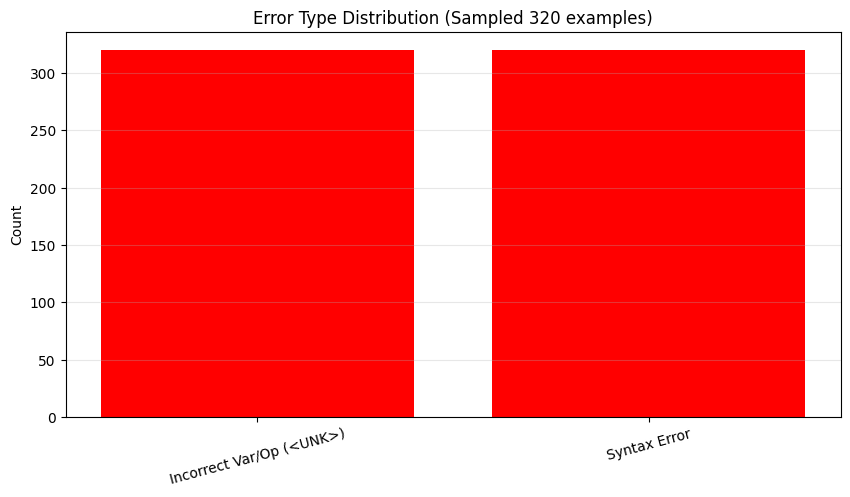

Error Counts: Counter({'Incorrect Var/Op (<UNK>)': 320, 'Syntax Error': 320})


In [32]:
import ast
import collections
import matplotlib.pyplot as plt

def analyze_generated_code_errors(model, loader, num_batches=5):
    """Generates code and categorizes errors using AST parsing."""
    model.eval()
    error_counts = collections.Counter()
    total_examples = 0
    
    print("Scanning for errors (Syntax, Indentation, Unknowns)...")
    
    with torch.no_grad():
        for batch_idx, (src, trg) in enumerate(loader):
            if batch_idx >= num_batches: break
            src = src.to(device)
            
            for i in range(len(src)):
                total_examples += 1
                
                # --- Generate Code ---
                # (Greedy decoding for speed)
                s = src[i].unsqueeze(0)
                mask = (s != PAD_IDX)
                
                # Encode
                enc_out, (h, c) = model.enc(model.drop(model.enc_emb(s)))
                h = torch.tanh(model.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                c = torch.tanh(model.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                
                # Decode
                inp = torch.tensor([SOS_IDX], device=device)
                gen_toks = []
                for _ in range(50):
                    emb = model.drop(model.dec_emb(inp.unsqueeze(1)))
                    ctx, _ = model.calc_attn(h[-1], enc_out, mask)
                    out, (h, c) = model.dec(torch.cat((emb, ctx.unsqueeze(1)), dim=2), (h, c))
                    pred = model.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
                    top = pred.argmax(1).item()
                    if top == EOS_IDX: break
                    gen_toks.append(trg_vocab.itos[top])
                    inp = torch.tensor([top], device=device)
                
                # --- Check Errors ---
                # Reconstruct string for AST parsing
                code_raw = " ".join(gen_toks)
                # Convert special tokens to actual Python syntax for checking
                code_fmt = code_raw.replace(' NEWLINE ', '\n').replace(' INDENT ', '    ')
                
                has_error = False
                
                # 1. Incorrect Operators/Variables (Heuristic: <UNK> token)
                if '<UNK>' in gen_toks:
                    error_counts['Incorrect Var/Op (<UNK>)'] += 1
                    has_error = True
                    
                # 2. Syntax & Indentation (using AST)
                try:
                    ast.parse(code_fmt)
                except IndentationError:
                    error_counts['Missing/Bad Indentation'] += 1
                    has_error = True
                except SyntaxError:
                    error_counts['Syntax Error'] += 1
                    has_error = True
                except Exception:
                    pass
                
                if not has_error:
                    error_counts['No Error'] += 1

    # --- Plotting ---
    labels = list(error_counts.keys())
    values = list(error_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=['green' if 'No' in l else 'red' for l in labels])
    plt.title(f"Error Type Distribution (Sampled {total_examples} examples)")
    plt.ylabel("Count")
    plt.xticks(rotation=15)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    print("Error Counts:", error_counts)

# Run Analysis on Attention Model
analyze_generated_code_errors(attn, test_loader)

## Attention Heatmap

Capturing attention maps for 3 examples...


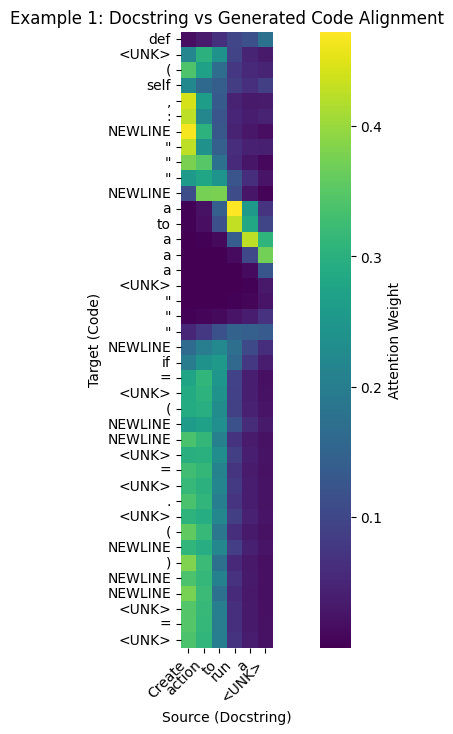

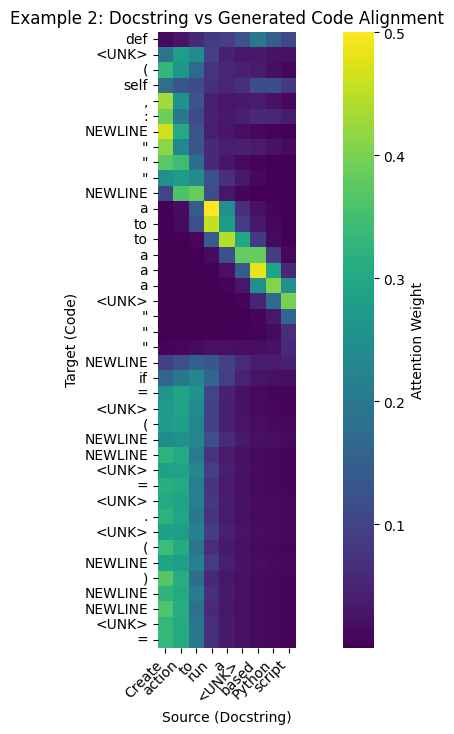

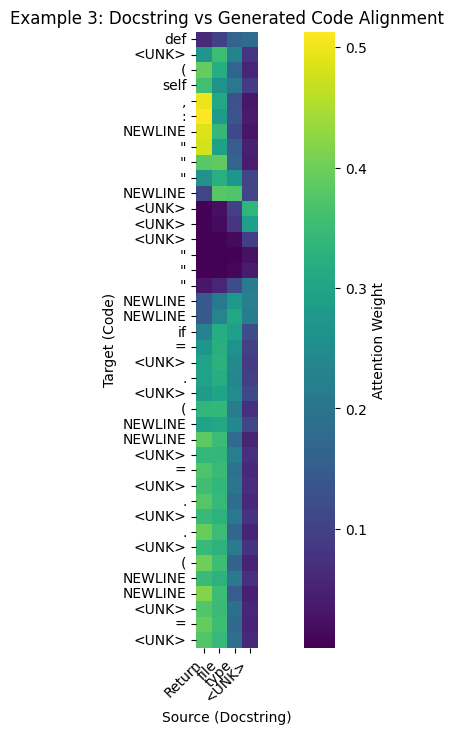

In [33]:
import seaborn as sns

def visualize_attention_alignment(model, loader):
    model.eval()
    captured_maps = []
    
    print("Capturing attention maps for 3 examples...")
    
    with torch.no_grad():
        for src, trg in loader:
            if len(captured_maps) >= 3: break
            src = src.to(device)
            
            for i in range(len(src)):
                if len(captured_maps) >= 3: break
                
                s = src[i].unsqueeze(0)
                mask = (s != PAD_IDX)
                
                # Encode
                enc_out, (h, c) = model.enc(model.drop(model.enc_emb(s)))
                h = torch.tanh(model.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                c = torch.tanh(model.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                
                # Decode & Capture Weights
                inp = torch.tensor([SOS_IDX], device=device)
                w_list = []
                gen_ids = []
                
                for _ in range(40): # Limit length for cleaner plots
                    emb = model.drop(model.dec_emb(inp.unsqueeze(1)))
                    ctx, w = model.calc_attn(h[-1], enc_out, mask)
                    w_list.append(w.cpu()) # Store attention weights
                    
                    out, (h, c) = model.dec(torch.cat((emb, ctx.unsqueeze(1)), dim=2), (h, c))
                    pred = model.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
                    top = pred.argmax(1).item()
                    
                    if top == EOS_IDX: break
                    gen_ids.append(top)
                    inp = torch.tensor([top], device=device)
                
                # Store if valid length
                if len(gen_ids) > 5:
                    src_tokens = [src_vocab.itos[t] for t in s[0].tolist() if t not in [PAD_IDX, SOS_IDX, EOS_IDX]]
                    trg_tokens = [trg_vocab.itos[t] for t in gen_ids]
                    # Stack weights: [Trg_Len, Src_Len]
                    matrix = torch.cat(w_list).numpy()[:len(trg_tokens), :len(src_tokens)]
                    captured_maps.append((src_tokens, trg_tokens, matrix))

    # Plot
    for idx, (src_toks, trg_toks, matrix) in enumerate(captured_maps):
        plt.figure(figsize=(12, 8))
        sns.heatmap(matrix, xticklabels=src_toks, yticklabels=trg_toks, cmap='viridis', square=True, cbar_kws={'label': 'Attention Weight'})
        plt.title(f"Example {idx+1}: Docstring vs Generated Code Alignment")
        plt.xlabel("Source (Docstring)")
        plt.ylabel("Target (Code)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.show()

# Run Visualization
visualize_attention_alignment(attn, test_loader)

## Semantic Interpretation

In [37]:
# --- 1. DEFINE THE INTERPRETER FUNCTION ---
def interpret_semantic_focus(src_toks, trg_toks, matrix):
    """
    Analyzes if attention focuses on relevant words by checking 
    if the max attention weight aligns with matching tokens.
    """
    print(f"\n--- Interpretation Analysis ---")
    
    # A. Diagonal Focus (Sequential Processing)
    rows, cols = matrix.shape
    if rows > 0 and cols > 0:
        diagonal_score = 0
        for r in range(rows):
            # Expected column (roughly proportional)
            expected_c = int((r / rows) * cols)
            # Check window around expected column (width 5)
            window = matrix[r, max(0, expected_c-2):min(cols, expected_c+3)]
            diagonal_score += window.sum()
        
        avg_diag_strength = diagonal_score / rows
        print(f"Sequential Focus Score: {avg_diag_strength:.4f}")
        if avg_diag_strength > 0.5:
            print(">> Interpretation: The model is reading the docstring sequentially (Good sign).")
        else:
            print(">> Interpretation: The model is jumping around or lost (Common in early training).")

    # B. Semantic Matching (Keyword Focus)
    hits = []
    for t_idx, t_word in enumerate(trg_toks):
        # Skip common stopwords for clearer analysis
        if t_word in ['(', ')', ':', 'def', 'self', '.', ',', 'import']: continue
        
        # Find if this word exists in source
        if t_word in src_toks:
            s_indices = [i for i, x in enumerate(src_toks) if x == t_word]
            # Check attention weight at those indices
            for s_idx in s_indices:
                weight = matrix[t_idx, s_idx]
                if weight > 0.15: # Lowered threshold slightly to catch weaker signals
                    hits.append(f"'{t_word}' (Code) attended to '{t_word}' (Doc) [Weight: {weight:.2f}]")
    
    if hits:
        print("Semantic Matches Found (Relevant Word Focus):")
        for h in hits[:5]: print(" - " + h)
    else:
        print("No direct word-copying observed.") 
        print("(Note: This is normal if the model is paraphrasing or if the docstring describes logic rather than naming variables directly.)")

# --- 2. RUN IT ON THE CAPTURED MAPS ---
# We use the 'captured_maps' variable from the previous "Visualize" step.
# If that variable is lost, we re-capture them briefly here.

if 'captured_maps' not in globals() or len(captured_maps) == 0:
    print("Re-capturing attention maps for analysis...")
    # Quick capture logic (same as before)
    attn.eval()
    captured_maps = []
    with torch.no_grad():
        for src, trg in test_loader:
            src = src.to(device)
            for i in range(len(src)):
                if len(captured_maps) >= 3: break
                s = src[i].unsqueeze(0)
                mask = (s != PAD_IDX)
                enc_out, (h, c) = attn.enc(attn.drop(attn.enc_emb(s)))
                h = torch.tanh(attn.fc_h(torch.cat((h[-2], h[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                c = torch.tanh(attn.fc_c(torch.cat((c[-2], c[-1]), dim=1))).unsqueeze(0).repeat(NUM_LAYERS, 1, 1)
                inp = torch.tensor([SOS_IDX], device=device)
                w_list, gen_ids = [], []
                for _ in range(40):
                    emb = attn.drop(attn.dec_emb(inp.unsqueeze(1)))
                    ctx, w = attn.calc_attn(h[-1], enc_out, mask)
                    w_list.append(w.cpu())
                    out, (h, c) = attn.dec(torch.cat((emb, ctx.unsqueeze(1)), dim=2), (h, c))
                    pred = attn.fc_out(torch.cat((out.squeeze(1), ctx, emb.squeeze(1)), dim=1))
                    top = pred.argmax(1).item()
                    if top == EOS_IDX: break
                    gen_ids.append(top); inp = torch.tensor([top], device=device)
                if len(gen_ids) > 5:
                    src_tokens = [src_vocab.itos[t] for t in s[0].tolist() if t not in [PAD_IDX, SOS_IDX, EOS_IDX]]
                    trg_tokens = [trg_vocab.itos[t] for t in gen_ids]
                    matrix = torch.cat(w_list).numpy()[:len(trg_tokens), :len(src_tokens)]
                    captured_maps.append((src_tokens, trg_tokens, matrix))
            if len(captured_maps) >= 3: break

# Execute Analysis
print(f"Analyzing {len(captured_maps)} Examples...")
for i, (s, t, m) in enumerate(captured_maps):
    print(f"\nExample {i+1}:")
    interpret_semantic_focus(s, t, m)

Re-capturing attention maps for analysis...
Analyzing 3 Examples...

Example 1:

--- Interpretation Analysis ---
Sequential Focus Score: 0.4650
>> Interpretation: The model is jumping around or lost (Common in early training).
Semantic Matches Found (Relevant Word Focus):
 - 'a' (Code) attended to 'a' (Doc) [Weight: 0.25]
 - 'a' (Code) attended to 'a' (Doc) [Weight: 0.43]

Example 2:

--- Interpretation Analysis ---
Sequential Focus Score: 0.3529
>> Interpretation: The model is jumping around or lost (Common in early training).
Semantic Matches Found (Relevant Word Focus):
 - 'a' (Code) attended to 'a' (Doc) [Weight: 0.25]

Example 3:

--- Interpretation Analysis ---
Sequential Focus Score: 0.7235
>> Interpretation: The model is reading the docstring sequentially (Good sign).
Semantic Matches Found (Relevant Word Focus):
 - '<UNK>' (Code) attended to '<UNK>' (Doc) [Weight: 0.34]
 - '<UNK>' (Code) attended to '<UNK>' (Doc) [Weight: 0.29]
